# SEGMENTATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage.morphology import watershed
from skimage import exposure
import mkl_fft as mf
from skimage import feature
from skimage.morphology import skeletonize

In [2]:
import sys
sys.path.insert(0, '/home/svoigt6/Projects/pymks')

import importlib
from filter_tools import gBlur, gGrad, local_avg, conv_dilate, mk_circle, do_rem_obj

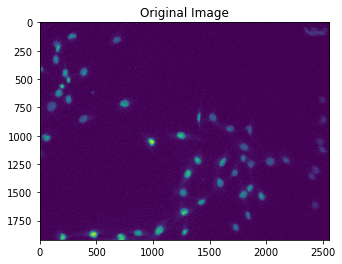

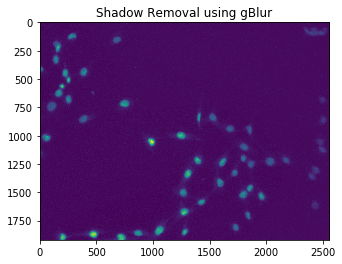

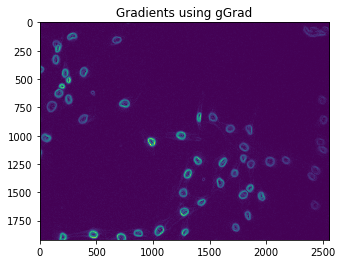

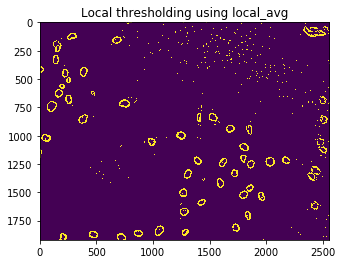

In [3]:
imgNum = 4
loc = 'fluorImgs2/b' + str(imgNum) + '.tif'
imgNuc = mpimg.imread(loc)

imgNew = imgNuc[:,:,1].copy()

plt.imshow(imgNew)
plt.title('Original Image')
plt.show()

imgNew = imgNew - gBlur(imgNew, 500)

plt.imshow(imgNew)
plt.title('Shadow Removal using gBlur')
plt.show()

grad1 = gGrad(imgNew, sigma = 4)

plt.imshow(grad1)
plt.title('Gradients using gGrad')
plt.show()

gradTh = grad1.copy()
gradTh = gradTh - local_avg(grad1, rad = 500)
gradTh = gradTh > local_avg(grad1, rad = 20)

plt.imshow(gradTh)
plt.title('Local thresholding using local_avg')
plt.show()

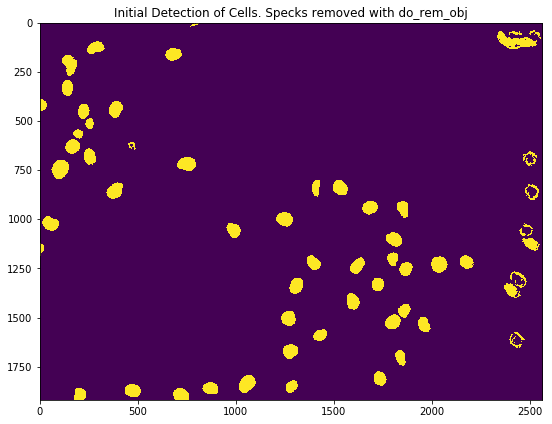

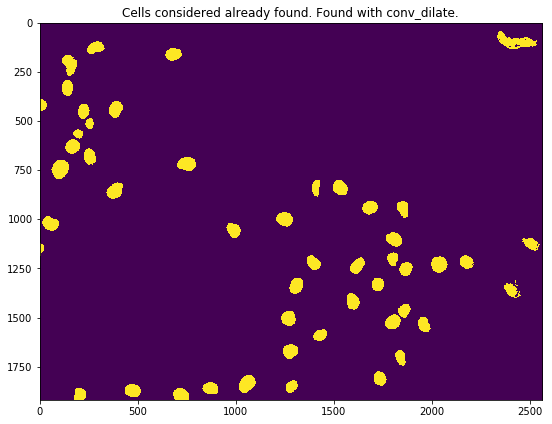

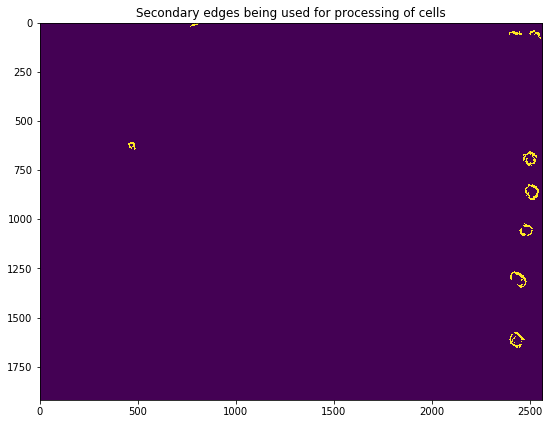

In [4]:
cells1 = gradTh.copy()

cells1, label_im = do_rem_obj(cells1, 200, 'less')
fills1, label_im = do_rem_obj(1-cells1, 20000, 'gre')
fills1, label_im = do_rem_obj(fills1, 200, 'less')

cells1 = cells1 + fills1

fig, axs = plt.subplots(1,1,figsize=(9,9))
axs.imshow(cells1)
axs.set_title('Initial Detection of Cells. Specks removed with do_rem_obj')
plt.show()

cells_already_found = (conv_dilate(fills1, 20) > 0.1).astype(np.int)

cells_to_process = (gradTh - cells_already_found) > 0

cells_to_process, label_im = do_rem_obj(cells_to_process, 200, 'less')

cells1 = (cells1-cells_to_process) > 0

fig, axs = plt.subplots(1,1,figsize=(9,9))
axs.imshow(cells1)
axs.set_title('Cells considered already found. Found with conv_dilate.')
plt.show()

fig, axs = plt.subplots(1,1,figsize=(9,9))
axs.imshow(cells_to_process)
axs.set_title('Secondary edges being used for processing of cells')
plt.show()

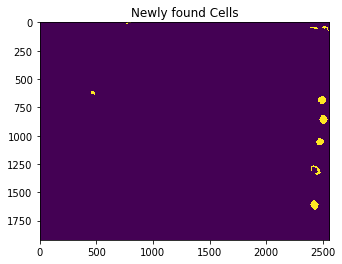

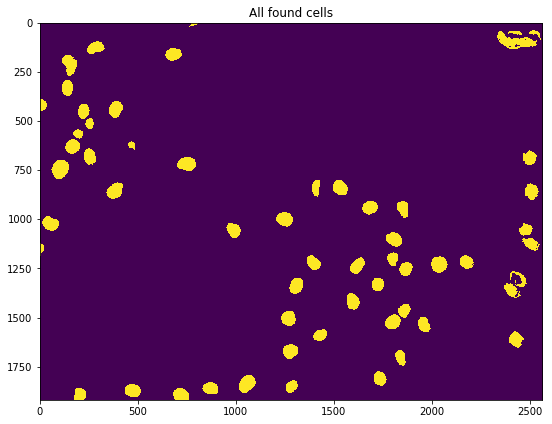

In [5]:
cells2 = cells_to_process.copy()

cells2 = (conv_dilate(cells2, 8) > 0.1).astype(np.int)
fills2, label_im = do_rem_obj(1-cells2, 50000, 'gre')

cells2 = cells2+fills2
cells2 = 1-(conv_dilate(1-cells2, 8) > 0.1)

plt.imshow(cells2)
plt.title('Newly found Cells')
plt.show()

cells_all = (cells1 + cells2) > 0

fig, axs = plt.subplots(1,1,figsize=(9,9))
axs.imshow(cells_all)
axs.set_title('All found cells')
plt.show()

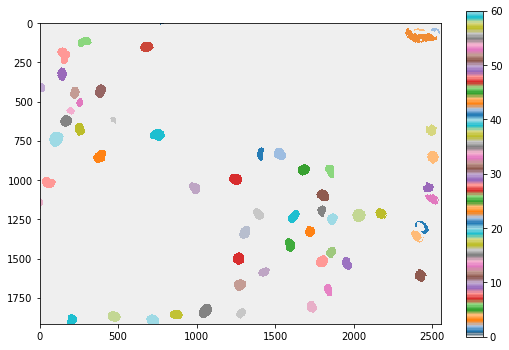

In [32]:
from matplotlib.colors import LinearSegmentedColormap
cells_labels, nb_labels = ndimage.label(cells_all)
cols = [plt.cm.tab20(i) for i in range(20)]
l = len(np.unique(label_im))
cols = [(0.07,0.07,0.07,0.07),] + cols * (l // 20)
cols = cols + cols[:((l % 20) - 1)]
fig, axs = plt.subplots(1,1, figsize=(9,6))
im = axs.imshow(cells_labels, cmap = LinearSegmentedColormap.from_list('cols', cols))
fig.colorbar(im, ax=axs)
plt.show()

In [63]:
from skimage.measure import regionprops

props = regionprops(cells_labels)

x, y = props[0].centroid
xs = (int(round(x)),)
ys = (int(round(y)),)
for i in props[1:]:
    x, y = i.centroid
    xs = xs + (int(round(x)),)
    ys = ys + (int(round(y)),)

markers = np.zeros(cells_labels.shape)
markers[xs,ys] = 1
markers = ndimage.label(markers)[0]

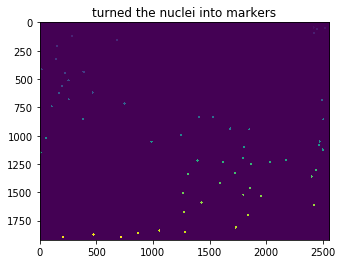

In [64]:
plt.imshow(conv_dilate(markers, 10))
plt.title('turned the nuclei into markers')
plt.show()

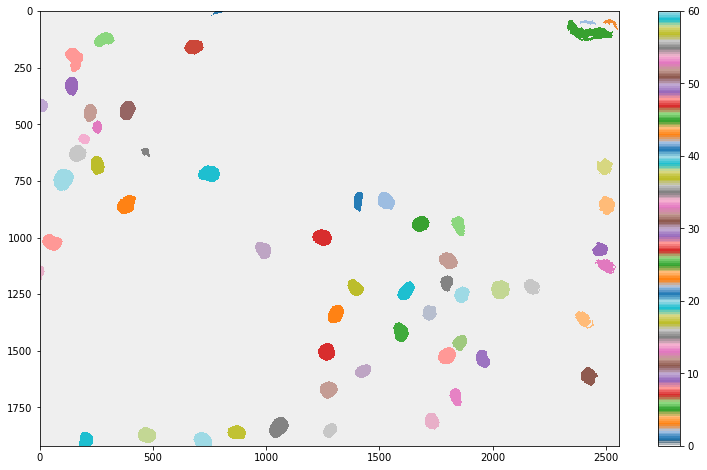

In [79]:
distance = ndimage.distance_transform_edt(cells_all)
labels_ws = watershed(-distance, markers, mask=cells_all)

plt.figure(figsize = (14,8))
cols = [plt.cm.tab20(i) for i in range(20)]
l = len(np.unique(labels_ws))
cols = [(0.07,0.07,0.07,0.07),] + cols * (l // 20)
cols = cols + cols[:((l % 20) - 1)]
plt.imshow(labels_ws, cmap = LinearSegmentedColormap.from_list('cols', cols))
plt.colorbar()
plt.show()

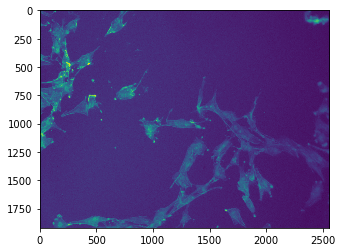

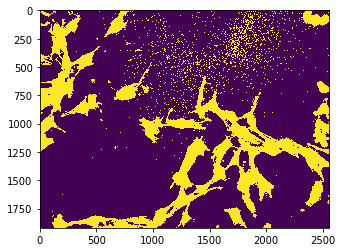

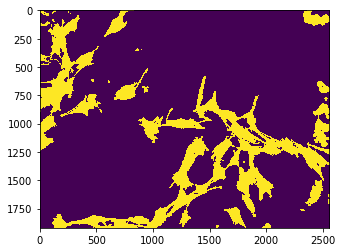

In [123]:
imgNum = 4

loc = 'fluorImgs2/g' + str(imgNum) + '.tif'
imgCyto = mpimg.imread(loc)

imgG = imgCyto[:,:,1]
imgG = imgG.astype(np.float)
imgG = imgG - gBlur(imgG, sigma = 500)

plt.imshow(imgG)
plt.show()

imgTh = imgG > local_avg(imgG, 1000)

plt.imshow(imgTh)
plt.show()

cyto1 = imgTh.copy()
cyto1 = 1 - (conv_dilate(1-cyto1, 2) > 0.1)
cyto1, label_im = do_rem_obj(cyto1, 200, 'less')
cyto1 = conv_dilate(cyto1, 2) > 0.1

plt.imshow(cyto1)
plt.show()

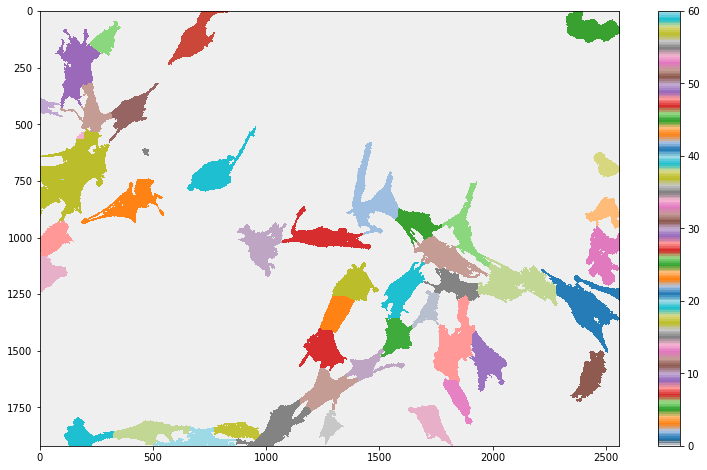

In [124]:
distance = ndimage.distance_transform_edt(cyto1)
labels_ws = watershed(-distance, markers, mask=cyto1)

plt.figure(figsize = (14,8))
cols = [plt.cm.tab20(i) for i in range(20)]
l = len(np.unique(labels_ws))
cols = [(0.07,0.07,0.07,0.07),] + cols * (l // 20)
cols = cols + cols[:((l % 20) - 1)]
plt.imshow(labels_ws, cmap = LinearSegmentedColormap.from_list('cols', cols))
plt.colorbar()
plt.show()